In [1]:
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
import os
import numpy as np

In [32]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
from sklearn.model_selection import StratifiedShuffleSplit
import time
import torch.multiprocessing as mp

# Use forkserver to avoid deadlock issues with JAX
mp.set_start_method('forkserver', force=True)

# Setup
data_dir = "/content/drive/MyDrive/gmm_team"  # Update this to the correct path
batch_size = 256  # Reduce if you encounter memory issues
num_workers = 0  # Reduce to 0 if necessary

# Data Transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.Pad(4),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load Dataset without any transforms
full_dataset = datasets.ImageFolder(root=data_dir)

# Split Dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
train_indices, remaining_indices = next(splitter.split(np.zeros(len(full_dataset)), full_dataset.targets))

remaining_splitter = StratifiedShuffleSplit(n_splits=1, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
val_indices, test_indices = next(remaining_splitter.split(np.zeros(len(remaining_indices)), np.array(full_dataset.targets)[remaining_indices]))

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path, label = self.dataset.imgs[self.indices[idx]]
        image = self.dataset.loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create Subsets with custom dataset class
train_dataset = CustomDataset(full_dataset, train_indices, transform=transform_train)
val_dataset = CustomDataset(full_dataset, val_indices, transform=val_test_transform)
test_dataset = CustomDataset(full_dataset, test_indices, transform=val_test_transform)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Print Dataset Information
class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Model Setup
model = models.alexnet(weights=None)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training Function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}
    dataloaders = {'train': train_loader, 'val': val_loader}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            total_batches = len(dataloaders[phase])
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Print progress
                batch_percentage = (batch_idx + 1) / total_batches * 100
                print(f'\r{phase.capitalize()} Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{total_batches}] - {batch_percentage:.2f}% Complete', end='')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'\n{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f'Epoch duration: {epoch_duration:.2f} seconds\n')

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# Optionally, save the trained model
torch.save(model.state_dict(), 'alexnet_best_model.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['cocci', 'healthy', 'ncd', 'salmo']
Training set size: 4768
Validation set size: 1022
Test set size: 1022
Epoch 0/9
----------
Train Epoch [1/10] Batch [19/19] - 100.00% Complete
train Loss: 1.3827 Acc: 0.3339
Val Epoch [1/10] Batch [4/4] - 100.00% Complete
val Loss: 1.3800 Acc: 0.0000
Epoch duration: 428.11 seconds

Epoch 1/9
----------
Train Epoch [2/10] Batch [19/19] - 100.00% Complete
train Loss: 1.3719 Acc: 0.3341
Val Epoch [2/10] Batch [4/4] - 100.00% Complete
val Loss: 1.3662 Acc: 0.0000
Epoch duration: 377.70 seconds

Epoch 2/9
----------
Train Epoch [3/10] Batch [19/19] - 100.00% Complete
train Loss: 1.3605 Acc: 0.3341
Val Epoch [3/10] Batch [4/4] - 100.00% Complete
val Loss: 1.3524 Acc: 0.0000
Epoch duration: 378.61 seconds

Epoch 3/9
----------
Train Epoch [4/10] Batch [6/19] - 31.58% Complete

KeyboardInterrupt: 

In [34]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import copy
from sklearn.model_selection import StratifiedShuffleSplit
import time
import torch.multiprocessing as mp

# Use forkserver to avoid deadlock issues with JAX
mp.set_start_method('forkserver', force=True)

# Setup
data_dir = "/content/drive/MyDrive/gmm_team"  # Update this to the correct path
batch_size = 256  # Reduce if you encounter memory issues
num_workers = 0  # Reduce to 0 if necessary

# Data Transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize((224, 224)),
    transforms.Pad(4),
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load Dataset without any transforms
full_dataset = datasets.ImageFolder(root=data_dir)

# Split Dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Stratified split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=(val_ratio + test_ratio), random_state=42)
train_indices, remaining_indices = next(splitter.split(np.zeros(len(full_dataset)), full_dataset.targets))

remaining_splitter = StratifiedShuffleSplit(n_splits=1, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
val_indices, test_indices = next(remaining_splitter.split(np.zeros(len(remaining_indices)), np.array(full_dataset.targets)[remaining_indices]))

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path, label = self.dataset.imgs[self.indices[idx]]
        image = self.dataset.loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create Subsets with custom dataset class
train_dataset = CustomDataset(full_dataset, train_indices, transform=transform_train)
val_dataset = CustomDataset(full_dataset, val_indices, transform=val_test_transform)
test_dataset = CustomDataset(full_dataset, test_indices, transform=val_test_transform)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Print Dataset Information
class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Model Setup
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training Function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}
    dataloaders = {'train': train_loader, 'val': val_loader}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            total_batches = len(dataloaders[phase])
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Print progress
                batch_percentage = (batch_idx + 1) / total_batches * 100
                print(f'\r{phase.capitalize()} Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{total_batches}] - {batch_percentage:.2f}% Complete', end='')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'\n{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f'Epoch duration: {epoch_duration:.2f} seconds\n')

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# Optionally, save the trained model
torch.save(model.state_dict(), 'alexnet_best_model.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['cocci', 'healthy', 'ncd', 'salmo']
Training set size: 4768
Validation set size: 1022
Test set size: 1022
Epoch 0/9
----------
Train Epoch [1/10] Batch [19/19] - 100.00% Complete
train Loss: 0.7408 Acc: 0.7431
Val Epoch [1/10] Batch [4/4] - 100.00% Complete
val Loss: 0.2062 Acc: 0.9560
Epoch duration: 393.78 seconds

Epoch 1/9
----------
Train Epoch [2/10] Batch [19/19] - 100.00% Complete
train Loss: 0.3159 Acc: 0.8800
Val Epoch [2/10] Batch [4/4] - 100.00% Complete
val Loss: 0.0507 Acc: 0.9853
Epoch duration: 378.53 seconds

Epoch 2/9
----------
Train Epoch [3/10] Batch [19/19] - 100.00% Complete
train Loss: 0.2301 Acc: 0.9140
Val Epoch [3/10] Batch [4/4] - 100.00% Complete
val Loss: 0.0362 Acc: 0.9902
Epoch duration: 378.96 seconds

Epoch 3/9
----------
Train Epoch [4/10] Batch [19/19] - 100.00% Complete
train Loss: 0.1844 Acc: 0.9327
Val Epoch [4

In [47]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter
import numpy as np

# Load Dataset without any transforms
full_dataset = datasets.ImageFolder(root=data_dir)

# Get targets for stratification
targets = np.array(full_dataset.targets)

# Split Dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Stratified split for training and remaining (validation + test)
train_indices, remaining_indices = train_test_split(
    np.arange(len(targets)),
    test_size=(val_ratio + test_ratio),
    stratify=targets,
    random_state=42
)

# Stratified split for validation and test from remaining
val_indices, test_indices = train_test_split(
    remaining_indices,
    test_size=(test_ratio / (val_ratio + test_ratio)),
    stratify=targets[remaining_indices],
    random_state=42
)

# Verify the distribution
train_labels = [targets[i] for i in train_indices]
val_labels = [targets[i] for i in val_indices]
test_labels = [targets[i] for i in test_indices]

print("Training set class distribution:", Counter(train_labels))
print("Validation set class distribution:", Counter(val_labels))
print("Test set class distribution:", Counter(test_labels))


# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path, label = self.dataset.imgs[self.indices[idx]]
        image = self.dataset.loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Create Subsets with custom dataset class
train_dataset = CustomDataset(full_dataset, train_indices, transform=transform_train)
val_dataset = CustomDataset(full_dataset, val_indices, transform=val_test_transform)
test_dataset = CustomDataset(full_dataset, test_indices, transform=val_test_transform)

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Print Dataset Information
class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set class distribution: Counter({3: 1593, 0: 1472, 1: 1440, 2: 263})
Validation set class distribution: Counter({3: 342, 0: 315, 1: 309, 2: 56})
Test set class distribution: Counter({3: 341, 0: 316, 1: 308, 2: 57})
Classes: ['cocci', 'healthy', 'ncd', 'salmo']
Training set size: 4768
Validation set size: 1022
Test set size: 1022


Test Loss: 0.0843 Acc: 0.9726
Class cocci: Precision: 0.9814, Recall: 1.0000, F1-Score: 0.9906
Class healthy: Precision: 0.9674, Recall: 0.9643, F1-Score: 0.9659
Class ncd: Precision: 0.9423, Recall: 0.8596, F1-Score: 0.8991
Class salmo: Precision: 0.9736, Recall: 0.9736, F1-Score: 0.9736

Classification Report:

              precision    recall  f1-score   support

       cocci       0.98      1.00      0.99       316
     healthy       0.97      0.96      0.97       308
         ncd       0.94      0.86      0.90        57
       salmo       0.97      0.97      0.97       341

    accuracy                           0.97      1022
   macro avg       0.97      0.95      0.96      1022
weighted avg       0.97      0.97      0.97      1022



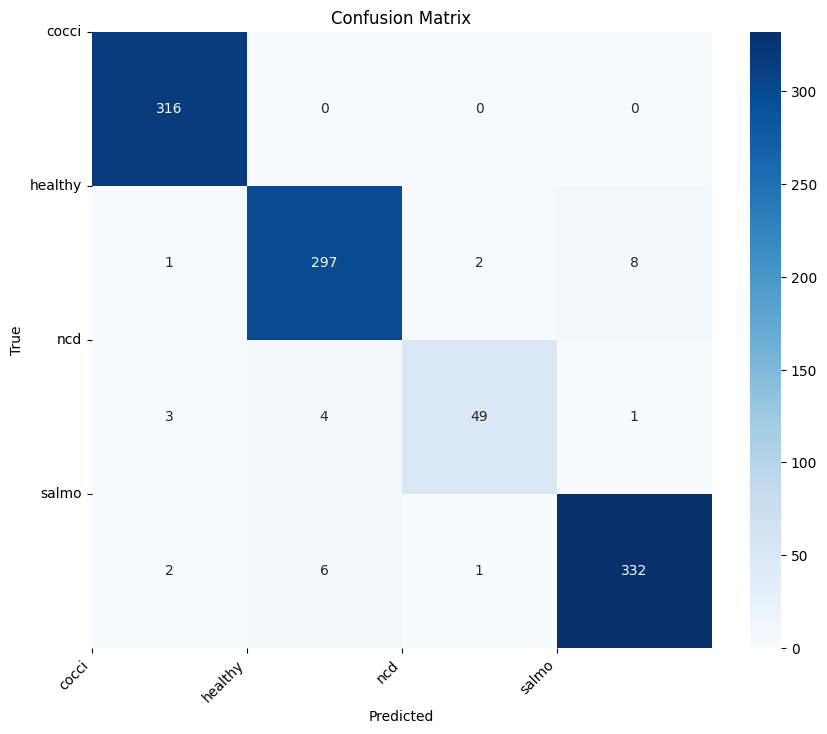

In [48]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
data_dir = "/content/drive/MyDrive/gmm_team"  # Update this to the correct path
batch_size = 256  # Reduce if you encounter memory issues
num_workers = 0  # Reduce to 0 if necessary

# Test Function

def test_model(model, criterion, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = accuracy_score(all_labels, all_preds)

    # Calculate precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=range(len(class_names)))

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    for i, class_name in enumerate(class_names):
        print(f'Class {class_name}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}')

    # Print classification report
    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=range(len(class_names))))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    ax.set_xticks(range(len(class_names)))
    ax.set_yticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_yticklabels(class_names, rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return test_loss, test_acc


# Load the best model weights
model.load_state_dict(torch.load('alexnet_best_model.pth'))

# Test the model
test_loss, test_acc = test_model(model, criterion, test_loader)


In [45]:
from collections import Counter

# Check the distribution of classes in each subset
train_labels = [full_dataset.targets[i] for i in train_indices]
val_labels = [full_dataset.targets[i] for i in val_indices]
test_labels = [full_dataset.targets[i] for i in test_indices]

print("Training set class distribution:", Counter(train_labels))
print("Validation set class distribution:", Counter(val_labels))
print("Test set class distribution:", Counter(test_labels))

Training set class distribution: Counter({3: 1593, 0: 1472, 1: 1440, 2: 263})
Validation set class distribution: Counter({0: 1022})
Test set class distribution: Counter({0: 1022})


In [39]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import copy
from sklearn.model_selection import train_test_split
import time

# Setup
data_dir = "/content/drive/MyDrive/gmm_team"  # Update this to the correct path
batch_size = 32  # Reduce if you encounter memory issues
num_workers = 4

# Data Transformations
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load Dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)

# Split Dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.shuffle(indices)

labels = [full_dataset.targets[i] for i in indices]

# First split: train and remaining (val + test)
train_indices, remaining_indices, train_labels, remaining_labels = train_test_split(indices, labels, test_size=val_ratio + test_ratio, stratify=labels, random_state=42)

# Second split: val and test
val_indices, test_indices, val_labels, test_labels = train_test_split(remaining_indices, remaining_labels, test_size=test_ratio / (test_ratio + val_ratio), stratify=remaining_labels, random_state=42)

train_subset = Subset(full_dataset, train_indices)
val_subset = Subset(full_dataset, val_indices)
test_subset = Subset(full_dataset, test_indices)

# Create Data Loaders
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Print Dataset Information
class_names = full_dataset.classes
print(f"Classes: {class_names}")
print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")
print(f"Test set size: {len(test_subset)}")

# Model Setup
model = models.alexnet(weights=None)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_names))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training Function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}
    dataloaders = {'train': train_loader, 'val': val_loader}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        epoch_start_time = time.time()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            total_batches = len(dataloaders[phase])
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Print progress
                batch_percentage = (batch_idx + 1) / total_batches * 100
                print(f'\r{phase.capitalize()} Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx+1}/{total_batches}] - {batch_percentage:.2f}% Complete', end='')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'\n{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f'Epoch duration: {epoch_duration:.2f} seconds\n')

    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=10)

# Optionally, save the trained model
torch.save(model.state_dict(), 'alexnet_best_model_no_pretrain.pth')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Classes: ['cocci', 'healthy', 'ncd', 'salmo']
Training set size: 4768
Validation set size: 1022
Test set size: 1022
Epoch 0/9
----------
Train Epoch [1/10] Batch [149/149] - 100.00% Complete
train Loss: 1.3123 Acc: 0.3375
Val Epoch [1/10] Batch [32/32] - 100.00% Complete
val Loss: 1.1925 Acc: 0.3102
Epoch duration: 149.45 seconds

Epoch 1/9
----------
Train Epoch [2/10] Batch [149/149] - 100.00% Complete
train Loss: 1.1070 Acc: 0.4499
Val Epoch [2/10] Batch [32/32] - 100.00% Complete
val Loss: 0.9690 Acc: 0.7358
Epoch duration: 129.53 seconds

Epoch 2/9
----------
Train Epoch [3/10] Batch [149/149] - 100.00% Complete
train Loss: 0.8503 Acc: 0.6760
Val Epoch [3/10] Batch [32/32] - 100.00% Complete
val Loss: 0.6524 Acc: 0.7564
Epoch duration: 130.36 seconds

Epoch 3/9
----------
Train Epoch [4/10] Batch [149/149] - 100.00% Complete
train Loss: 0.6503 Acc: 0.776

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss: 0.3162 Acc: 0.8963
Class cocci: Precision: 0.8968, Recall: 0.9905, F1-Score: 0.9414
Class healthy: Precision: 0.9175, Recall: 0.9026, F1-Score: 0.9100
Class ncd: Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Class salmo: Precision: 0.8784, Recall: 0.9531, F1-Score: 0.9142


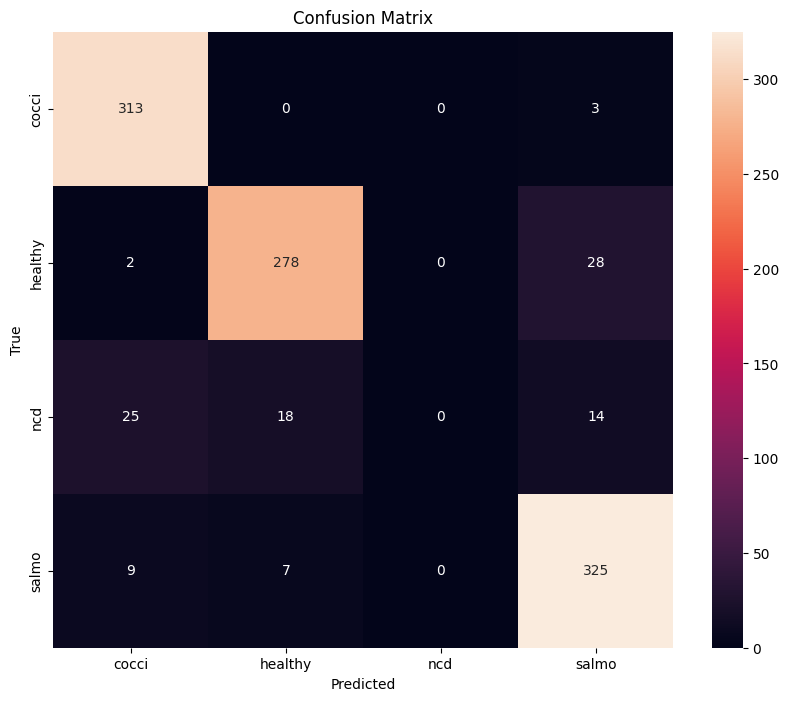

In [40]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Test Function
def test_model(model, criterion, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_acc = accuracy_score(all_labels, all_preds)

    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=range(len(class_names)))

    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    for i, class_name in enumerate(class_names):
        print(f'Class {class_name}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-Score: {f1[i]:.4f}')

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(cm, annot=True, fmt='d')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return test_loss, test_acc

# Load the best model weights
model.load_state_dict(torch.load('alexnet_best_model_no_pretrain.pth'))

# Test the model
test_loss, test_acc = test_model(model, criterion, test_loader)
